(array([[0., 5., 0., 2., 0., 2., 1., 0., 0., 0.],
        [0., 4., 0., 2., 0., 1., 1., 0., 2., 0.],
        [1., 4., 0., 2., 0., 1., 2., 0., 0., 0.],
        [0., 1., 0., 3., 0., 4., 0., 0., 1., 1.],
        [1., 2., 0., 1., 0., 4., 1., 0., 0., 1.]]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 5 BarContainer objects>)

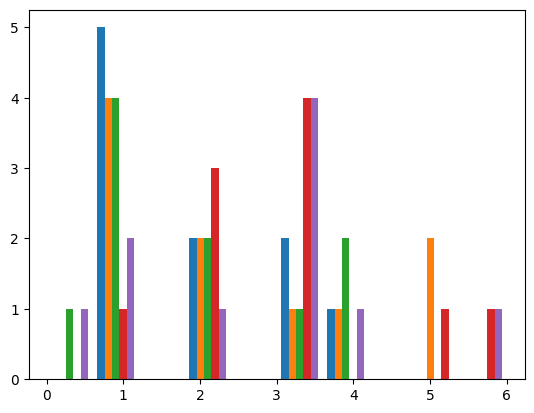

In [1]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

# Load environment variables
load_dotenv()
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')

# Initialize BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

# Get ophys experiments
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load Transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"
with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

stimuli = transfr['natural_movie_one']

experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

stim_table = data_set_regression.get_stimulus_table('natural_movie_one')

def generate_event_count_vector_levels(trial_ind, neuron_ind, transformer_emb_ind):
    ts = stim_table[stim_table['repeat'] == trial_ind]['start'].values
    neuron=data_set_events[neuron_ind,ts]
    embeddings = stimuli[:,transformer_emb_ind]
    # Partition the embeddings into 5 levels based on quantiles
    quantiles = np.percentile(embeddings, [20, 40, 60, 80])
    bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
    levels = np.digitize(embeddings, bins) - 1 

    event_values_per_level = []
    for level in range(5):
        indices = np.where(levels == level)[0]
        event_values = neuron[indices]
        event_values_per_level.append(event_values)

    event_values_per_level = np.array(event_values_per_level)
    event_values_nonzero=np.count_nonzero(event_values_per_level, axis=1)

    return event_values_nonzero

neuron_trial_counts=[]

for trial in range(10):
    neuron_trial_counts.append(generate_event_count_vector_levels(trial, 6, 0))

neuron_trial_counts=np.array(neuron_trial_counts)

plt.hist(neuron_trial_counts)

In [5]:
import numpy as np

# Assuming neuron_trial_counts is already defined
# Shape of neuron_trial_counts: (num_trials, num_levels)
num_trials, num_levels = neuron_trial_counts.shape

# Flatten the counts
counts = neuron_trial_counts.flatten()  # Shape: (num_trials * num_levels,)

# Create an array for levels (repeating each level for all trials)
levels = np.tile(np.arange(num_levels), num_trials)  # Shape: (num_trials * num_levels,)

# Create an array for trials (repeating each trial index for all levels)
trials = np.repeat(np.arange(num_trials), num_levels)  # Shape: (num_trials * num_levels,)

levels
trials
counts


array([4, 1, 1, 3, 4, 1, 3, 2, 1, 6, 2, 4, 4, 5, 3, 1, 2, 1, 3, 2, 1, 5,
       0, 2, 0, 3, 2, 4, 3, 1, 3, 1, 2, 2, 3, 2, 5, 3, 2, 1, 1, 1, 1, 3,
       3, 1, 1, 1, 6, 3])

In [6]:
# Total number of observations
N = counts.size  # Should be num_trials * num_levels

# Count the occurrences of each level
counts_per_level = np.bincount(levels, minlength=num_levels)  # Shape: (num_levels,)

# Calculate p(level)
p_level = counts_per_level / N  # Shape: (num_levels,)

print("p(level):")
for lvl in range(num_levels):
    print(f"Level {lvl}: {p_level[lvl]:.4f}")


p(level):
Level 0: 0.2000
Level 1: 0.2000
Level 2: 0.2000
Level 3: 0.2000
Level 4: 0.2000


In [7]:
# Find the maximum count to determine the range of counts
max_count = counts.max()

# Count the occurrences of each count value
counts_per_count = np.bincount(counts, minlength=max_count + 1)  # Shape: (max_count + 1,)

# Calculate p(count)
p_count = counts_per_count / N  # Shape: (max_count + 1,)

print("\np(count):")
for cnt in range(max_count + 1):
    print(f"Count {cnt}: {p_count[cnt]:.4f}")



p(count):
Count 0: 0.0400
Count 1: 0.3200
Count 2: 0.2000
Count 3: 0.2400
Count 4: 0.1000
Count 5: 0.0600
Count 6: 0.0400


In [8]:
# Create a 2D array to hold joint counts
joint_counts = np.zeros((num_levels, max_count + 1), dtype=int)  # Shape: (num_levels, max_count + 1)

# Populate the joint counts
for lvl, cnt in zip(levels, counts):
    joint_counts[lvl, cnt] += 1

# Calculate p(level, count)
p_level_count = joint_counts / N  # Shape: (num_levels, max_count + 1)

print("\np(level, count):")
for lvl in range(num_levels):
    for cnt in range(max_count + 1):
        prob = p_level_count[lvl, cnt]
        if prob > 0:
            print(f"Level {lvl}, Count {cnt}: {prob:.4f}")



p(level, count):
Level 0, Count 1: 0.1000
Level 0, Count 2: 0.0400
Level 0, Count 3: 0.0400
Level 0, Count 4: 0.0200
Level 1, Count 1: 0.0800
Level 1, Count 2: 0.0400
Level 1, Count 3: 0.0200
Level 1, Count 4: 0.0200
Level 1, Count 5: 0.0400
Level 2, Count 0: 0.0200
Level 2, Count 1: 0.0800
Level 2, Count 2: 0.0400
Level 2, Count 3: 0.0200
Level 2, Count 4: 0.0400
Level 3, Count 1: 0.0200
Level 3, Count 2: 0.0600
Level 3, Count 3: 0.0800
Level 3, Count 5: 0.0200
Level 3, Count 6: 0.0200
Level 4, Count 0: 0.0200
Level 4, Count 1: 0.0400
Level 4, Count 2: 0.0200
Level 4, Count 3: 0.0800
Level 4, Count 4: 0.0200
Level 4, Count 6: 0.0200


In [9]:
# Marginal over counts (summing over levels)
p_count_marginal = np.sum(p_level_count, axis=0)  # Shape: (max_count + 1,)
# Marginal over levels (summing over counts)
p_level_marginal = np.sum(p_level_count, axis=1)  # Shape: (num_levels,)

# Compare with previous p(count)
assert np.allclose(p_count, p_count_marginal), "Marginal p(count) does not match."

# Compare with previous p(level)
assert np.allclose(p_level, p_level_marginal), "Marginal p(level) does not match."


In [10]:
import numpy as np

# Assuming the previous code has been run and we have:
# p_level: probability distribution over levels
# p_count: probability distribution over counts
# p_level_count: joint probability distribution over levels and counts

# Compute mutual information
mutual_info = 0.0

for lvl in range(num_levels):
    for cnt in range(max_count + 1):
        p_joint = p_level_count[lvl, cnt]
        if p_joint > 0:
            p_lvl = p_level[lvl]
            p_cnt = p_count[cnt]
            mutual_info += p_joint * np.log2(p_joint / (p_lvl * p_cnt))

print(f"\nMutual Information I(Level; Count): {mutual_info:.4f} bits")



Mutual Information I(Level; Count): 0.3572 bits


In [12]:
import numpy as np

# Assuming the previous code has been run and we have:
# p_level: probability distribution over levels
# p_count: probability distribution over counts
# p_level_count: joint probability distribution over levels and counts

# Compute expected joint probabilities under independence
expected_p_level_count = np.outer(p_level, p_count)  # Shape: (num_levels, max_count + 1)

# Compute the differences between observed and expected joint probabilities
diff = p_level_count - expected_p_level_count

# Set a tolerance for considering probabilities equal (due to floating-point precision)
tolerance = 1e-6

# Check if all differences are within the tolerance
independent = np.all(np.abs(diff) < tolerance)

if independent:
    print("\nLevel and Count are independent (within the tolerance).")
else:
    print("\nLevel and Count are not independent.")

# Optionally, print the differences
print("\nDifferences between observed and expected joint probabilities:")
for lvl in range(num_levels):
    for cnt in range(max_count + 1):
        observed = p_level_count[lvl, cnt]
        expected = expected_p_level_count[lvl, cnt]
        difference = observed - expected
        if np.abs(difference) > tolerance:
            print(f"Level {lvl}, Count {cnt}: Observed = {observed:.6f}, Expected = {expected:.6f}, Difference = {difference:.6f}")

# Print the maximum absolute difference
max_diff = np.max(np.abs(diff))
print(f"\nMaximum absolute difference: {max_diff:.6f}")



Level and Count are not independent.

Differences between observed and expected joint probabilities:
Level 0, Count 0: Observed = 0.000000, Expected = 0.008000, Difference = -0.008000
Level 0, Count 1: Observed = 0.100000, Expected = 0.064000, Difference = 0.036000
Level 0, Count 3: Observed = 0.040000, Expected = 0.048000, Difference = -0.008000
Level 0, Count 5: Observed = 0.000000, Expected = 0.012000, Difference = -0.012000
Level 0, Count 6: Observed = 0.000000, Expected = 0.008000, Difference = -0.008000
Level 1, Count 0: Observed = 0.000000, Expected = 0.008000, Difference = -0.008000
Level 1, Count 1: Observed = 0.080000, Expected = 0.064000, Difference = 0.016000
Level 1, Count 3: Observed = 0.020000, Expected = 0.048000, Difference = -0.028000
Level 1, Count 5: Observed = 0.040000, Expected = 0.012000, Difference = 0.028000
Level 1, Count 6: Observed = 0.000000, Expected = 0.008000, Difference = -0.008000
Level 2, Count 0: Observed = 0.020000, Expected = 0.008000, Difference 

Observed Mutual Information: 0.3572 bits
P-value from permutation test: 0.6803

The observed mutual information is not statistically significant (p >= 0.05).


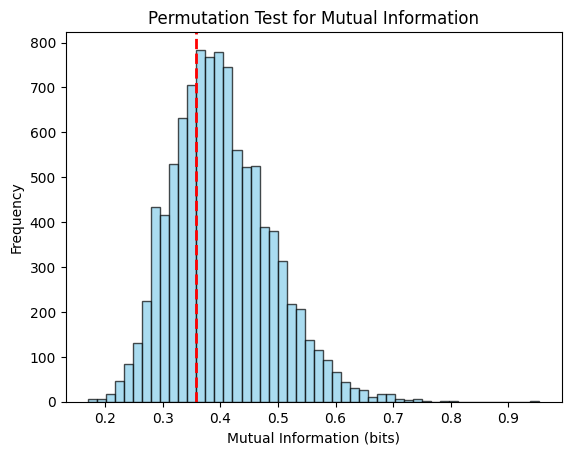

In [13]:
import numpy as np

# Assuming you have already calculated the following from your data:
# counts: Flattened array of neuron event counts
# levels: Corresponding array of levels for each count
# p_level: Probability distribution over levels
# p_count: Probability distribution over counts
# p_level_count: Joint probability distribution over levels and counts
# mutual_info: Observed mutual information between Level and Count

# If not, make sure to run the code to calculate these before proceeding.

# Set the number of permutations
num_permutations = 10000  # You can adjust this number based on your computational resources

# Initialize an array to store mutual information values from permutations
perm_mutual_info = np.zeros(num_permutations)

# Concatenate counts and levels into a single dataset for permutation
data = np.column_stack((levels, counts))

# Calculate the observed mutual information (if not already calculated)
def compute_mutual_information(levels, counts, num_levels, max_count):
    N = len(counts)
    # Recompute probabilities based on shuffled levels
    counts_per_level = np.bincount(levels, minlength=num_levels)
    p_level = counts_per_level / N
    
    counts_per_count = np.bincount(counts, minlength=max_count + 1)
    p_count = counts_per_count / N
    
    joint_counts = np.zeros((num_levels, max_count + 1), dtype=int)
    for lvl, cnt in zip(levels, counts):
        joint_counts[lvl, cnt] += 1
    p_level_count = joint_counts / N
    
    # Compute mutual information
    mutual_info = 0.0
    for lvl in range(num_levels):
        for cnt in range(max_count + 1):
            p_joint = p_level_count[lvl, cnt]
            if p_joint > 0:
                p_lvl = p_level[lvl]
                p_cnt = p_count[cnt]
                mutual_info += p_joint * np.log2(p_joint / (p_lvl * p_cnt))
    return mutual_info

# Get the number of levels and max count (if not already defined)
num_levels = np.unique(levels).size
max_count = counts.max()

# Perform permutations
for i in range(num_permutations):
    # Permute the levels
    permuted_levels = np.random.permutation(levels)
    
    # Compute mutual information for the permuted data
    mi = compute_mutual_information(permuted_levels, counts, num_levels, max_count)
    perm_mutual_info[i] = mi

# Calculate the p-value
# The p-value is the proportion of permuted mutual information values
# that are greater than or equal to the observed mutual information
p_value = np.sum(perm_mutual_info >= mutual_info) / num_permutations

print(f"Observed Mutual Information: {mutual_info:.4f} bits")
print(f"P-value from permutation test: {p_value:.4f}")

if p_value < 0.05:
    print("\nThe observed mutual information is statistically significant (p < 0.05).")
else:
    print("\nThe observed mutual information is not statistically significant (p >= 0.05).")

# Optional: Plot the distribution of permuted mutual information values
import matplotlib.pyplot as plt

plt.hist(perm_mutual_info, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(mutual_info, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Mutual Information (bits)')
plt.ylabel('Frequency')
plt.title('Permutation Test for Mutual Information')
plt.show()
